In [1]:
#import packages
import numpy as np
import seaborn as sns
import pandas as pd

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

#np.random.seed(12345)

import tensorflow.keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras import initializers, regularizers
from tensorflow.keras import optimizers
from keras.utils.layer_utils import count_params
from tensorflow.keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.manifold import TSNE

Using TensorFlow backend.


In [2]:
data = 'DATA/data_t-SNE_310101_d5_R100_e1_N800.dat'
columns=['x1','x2','x3','x4','x5']

#df_raw will not contain labels
df_raw = pd.read_csv(data, delimiter='\t',header=None, names=columns)
N=len(df_raw)

df = df_raw.copy(deep=True)

label0 = np.full(int(N*0.1),0)
label1 = np.full(int(N*0.3),1)
label2 = np.full(int(N*0.6),2)
label = np.concatenate([label0,label1,label2])

#df will also contain labels
df['label'] = label

In [3]:
df.head(5)

,x1,x2,x3,x4,x5,label
0,-83065,29521,68815,-100340,-29235,0
1,-110304,38545,68519,-115776,-46287,0
2,-88908,31418,69174,-107023,-30120,0
3,-99298,32751,71580,-113674,-38766,0
4,-77225,29431,64216,-95754,-28018,0


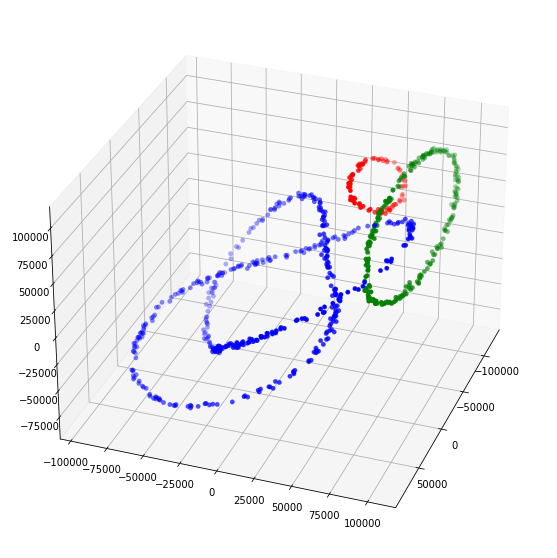

In [53]:
fig = plt.figure(figsize=(15,10))

red = df['label'] == 0
green = df['label'] == 1
blue = df['label'] == 2

ax = fig.gca(projection='3d')
ax.scatter(df[red]['x1'], df[red]['x2'], df[red]['x3'], c='red', linewidth=0.2)
ax.scatter(df[green]['x1'], df[green]['x2'], df[green]['x3'], c='green', linewidth=0.2)
ax.scatter(df[blue]['x1'], df[blue]['x2'], df[blue]['x3'], c='blue', linewidth=0.2)
ax.view_init(30, 20)
plt.show()
#funzia

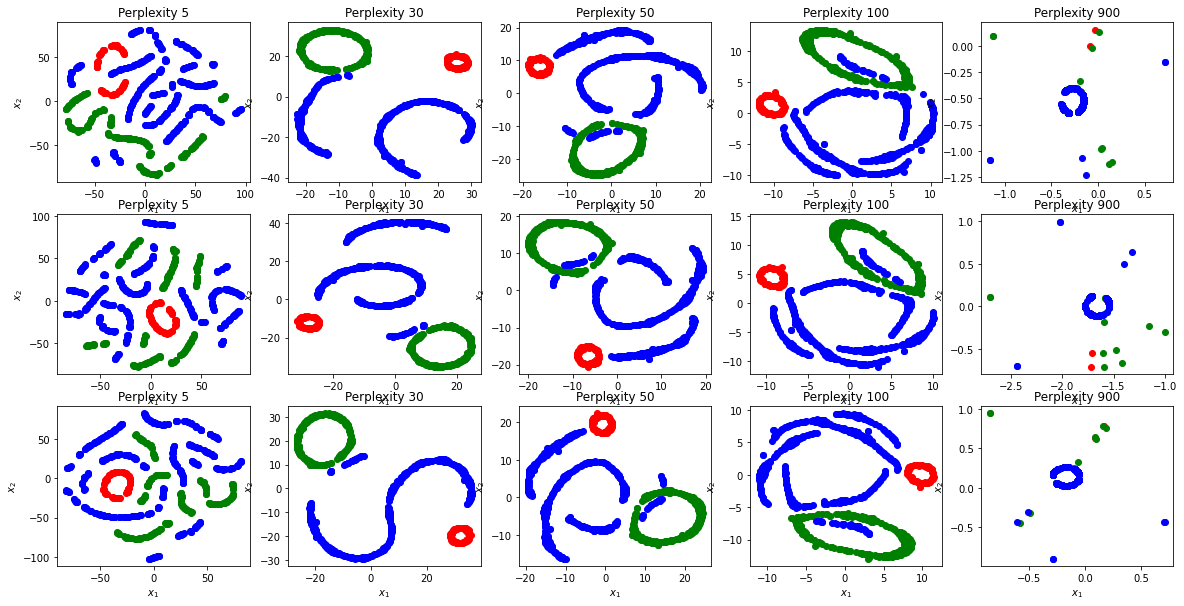

In [54]:
fig, ax = plt.subplots(3,5, figsize=(20,10))
perplexity_list = [5,30,50,100,900]

for i in range(3):
    for j in range(len(perplexity_list)):
        X_embedded = TSNE(n_components=2,  perplexity=perplexity_list[j]).fit_transform(df)
        x = np.array([X_embedded[j][0] for j in range(X_embedded.shape[0])] )
        y = np.array([X_embedded[j][1] for j in range(X_embedded.shape[0])] )
        ax[i][j].set_title(f'Perplexity {perplexity_list[j]}')
        ax[i][j].set_xlabel('$x_1$')
        ax[i][j].set_ylabel('$x_2$')
        ax[i][j].scatter(x[red],y[red], color = 'red')
        ax[i][j].scatter(x[green],y[green], color = 'green')
        ax[i][j].scatter(x[blue],y[blue], color = 'blue')

plt.show()

In [97]:
X_embedded = TSNE(n_components=2,  perplexity=30).fit_transform(df)
print(X_embedded.shape)

(800, 2)


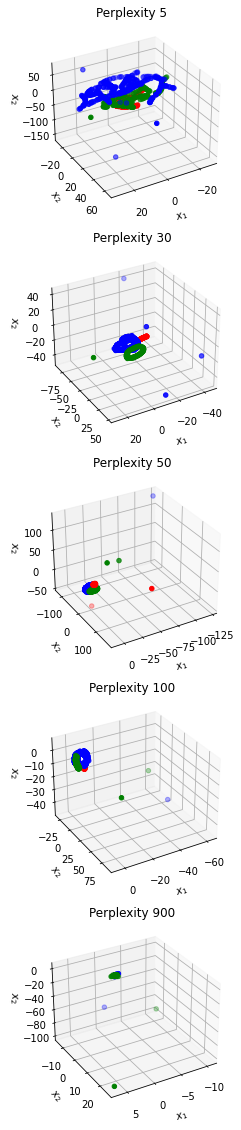

In [55]:
fig = plt.figure(figsize=(20,20))

for i in range(len(perplexity_list)):
    ax   = fig.add_subplot(len(perplexity_list), 1, i+1, projection='3d')
    X_embedded = TSNE(n_components=3, perplexity=perplexity_list[i]).fit_transform(df)
    x = np.array([X_embedded[j][0] for j in range(X_embedded.shape[0])] )
    y = np.array([X_embedded[j][1] for j in range(X_embedded.shape[0])] )
    z = np.array([X_embedded[j][2] for j in range(X_embedded.shape[0])] )
    ax.set_title(f'Perplexity {perplexity_list[i]}')
    ax.set_xlabel('$x_1$')
    ax.set_ylabel('$x_2$')
    ax.set_zlabel('$x_2$')
    ax.scatter(x[red],y[red],z[red], color = 'red')
    ax.scatter(x[green],y[green],z[green], color = 'green')
    ax.scatter(x[blue],y[blue],z[blue], color = 'blue')
    ax.view_init(30, 60)
        
plt.show()

## Optimal EPS calculation

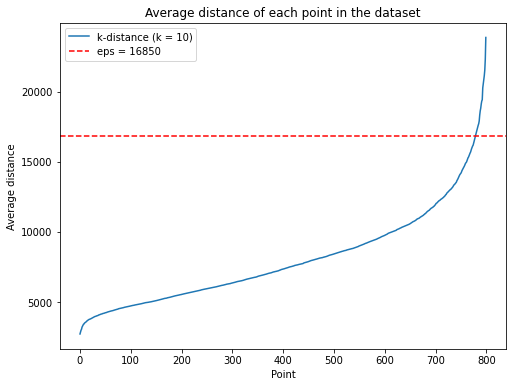

In [42]:
from sklearn.neighbors import NearestNeighbors

plt.figure(figsize=(8,6))
def find_slope(dist, pct = 0.01):
    flag = 0
    epsilon = 0
    for i in range(200,len(dist)):
        if flag == 0: 
            if dist[i+1]/dist[i] > (1+pct):
                epsilon = (dist[i]+dist[i+1])/2.
                flag = 1 
    return epsilon

dataset = df_raw.copy()

neighbors = NearestNeighbors(n_neighbors=11)
neighbors_fit = neighbors.fit(dataset)
distances, indices = neighbors_fit.kneighbors(dataset)
#ordering distances from smaller to higher
distances = np.sort(distances, axis=0)
#removing the distance from the point to itself
distances = distances[:,1:]
#taking the average, if not, eps will be underestimated
distances = distances.mean(axis=1)
eps = find_slope(distances,.01)

plt.plot(distances, label = 'k-distance (k = 10)')
plt.title('Average distance of each point in the dataset')
plt.xlabel('Point')
plt.ylabel('Average distance')
plt.axhline(eps, c='r', ls = '--', label = 'eps = {}'.format(int(eps)))
plt.legend()
plt.show()

In [49]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from collections import OrderedDict

X = df_raw.to_numpy()
y_true = df['label']

cpalette = ["#1CE6FF", "#FF34FF", "#FF4A46","#008941", "#006FA6", "#A30059", "#0000A6", "#63FFAC","#B79762", "#004D43", "#8FB0FF", "#997D87","#5A0007", "#809693","#1B4400", "#4FC601", "#3B5DFF", "#4A3B53","#886F4C","#34362D", "#B4A8BD", "#00A6AA", "#452C2C","#636375", "#A3C8C9", "#FF913F", "#938A81","#575329", "#00FECF", "#B05B6F"]

# Normalized mutual information function
# Note that this deals with the label permutation problem

def clustering(y):
    # Finds position of labels and returns a dictionary of cluster labels to data indices.
    yu = np.sort(np.unique(y))
    clustering = OrderedDict()
    for ye in yu:
        clustering[ye] = np.where(y == ye)[0]
    return clustering

def NMI(y_true, y_pred):
    """ Computes normalized mutual information: where y_true and y_pred are both clustering assignments
    """
    w = clustering(y_true)
    c = clustering(y_pred)
    n_sample = len(y_true)

    Iwc = 0.
    for kw in w.keys():
        for kc in c.keys():
            w_intersect_c=len(set(w[kw]).intersection(set(c[kc])))
            if w_intersect_c > 0:
                Iwc += w_intersect_c*np.log(n_sample*w_intersect_c/(len(w[kw])*len(c[kc])))
    Iwc/=n_sample
    Hc = entropy(c,n_sample)
    Hw = entropy(w,n_sample)

    return 2*Iwc/(Hc+Hw)

def entropy(c, n_sample):
    # Measures the entropy of a cluster
    h = 0.
    for kc in c.keys():
        p=len(c[kc])/n_sample
        h+=p*np.log(p)
    h*=-1.
    return h

def plotting_ax(X, y, ax):
    # plotting function
    for i, yu in enumerate(np.unique(y)):
        pos = (y == yu)
        ax.scatter(X[pos,0], X[pos,1],c=cpalette[i%len(cpalette)],s=4)

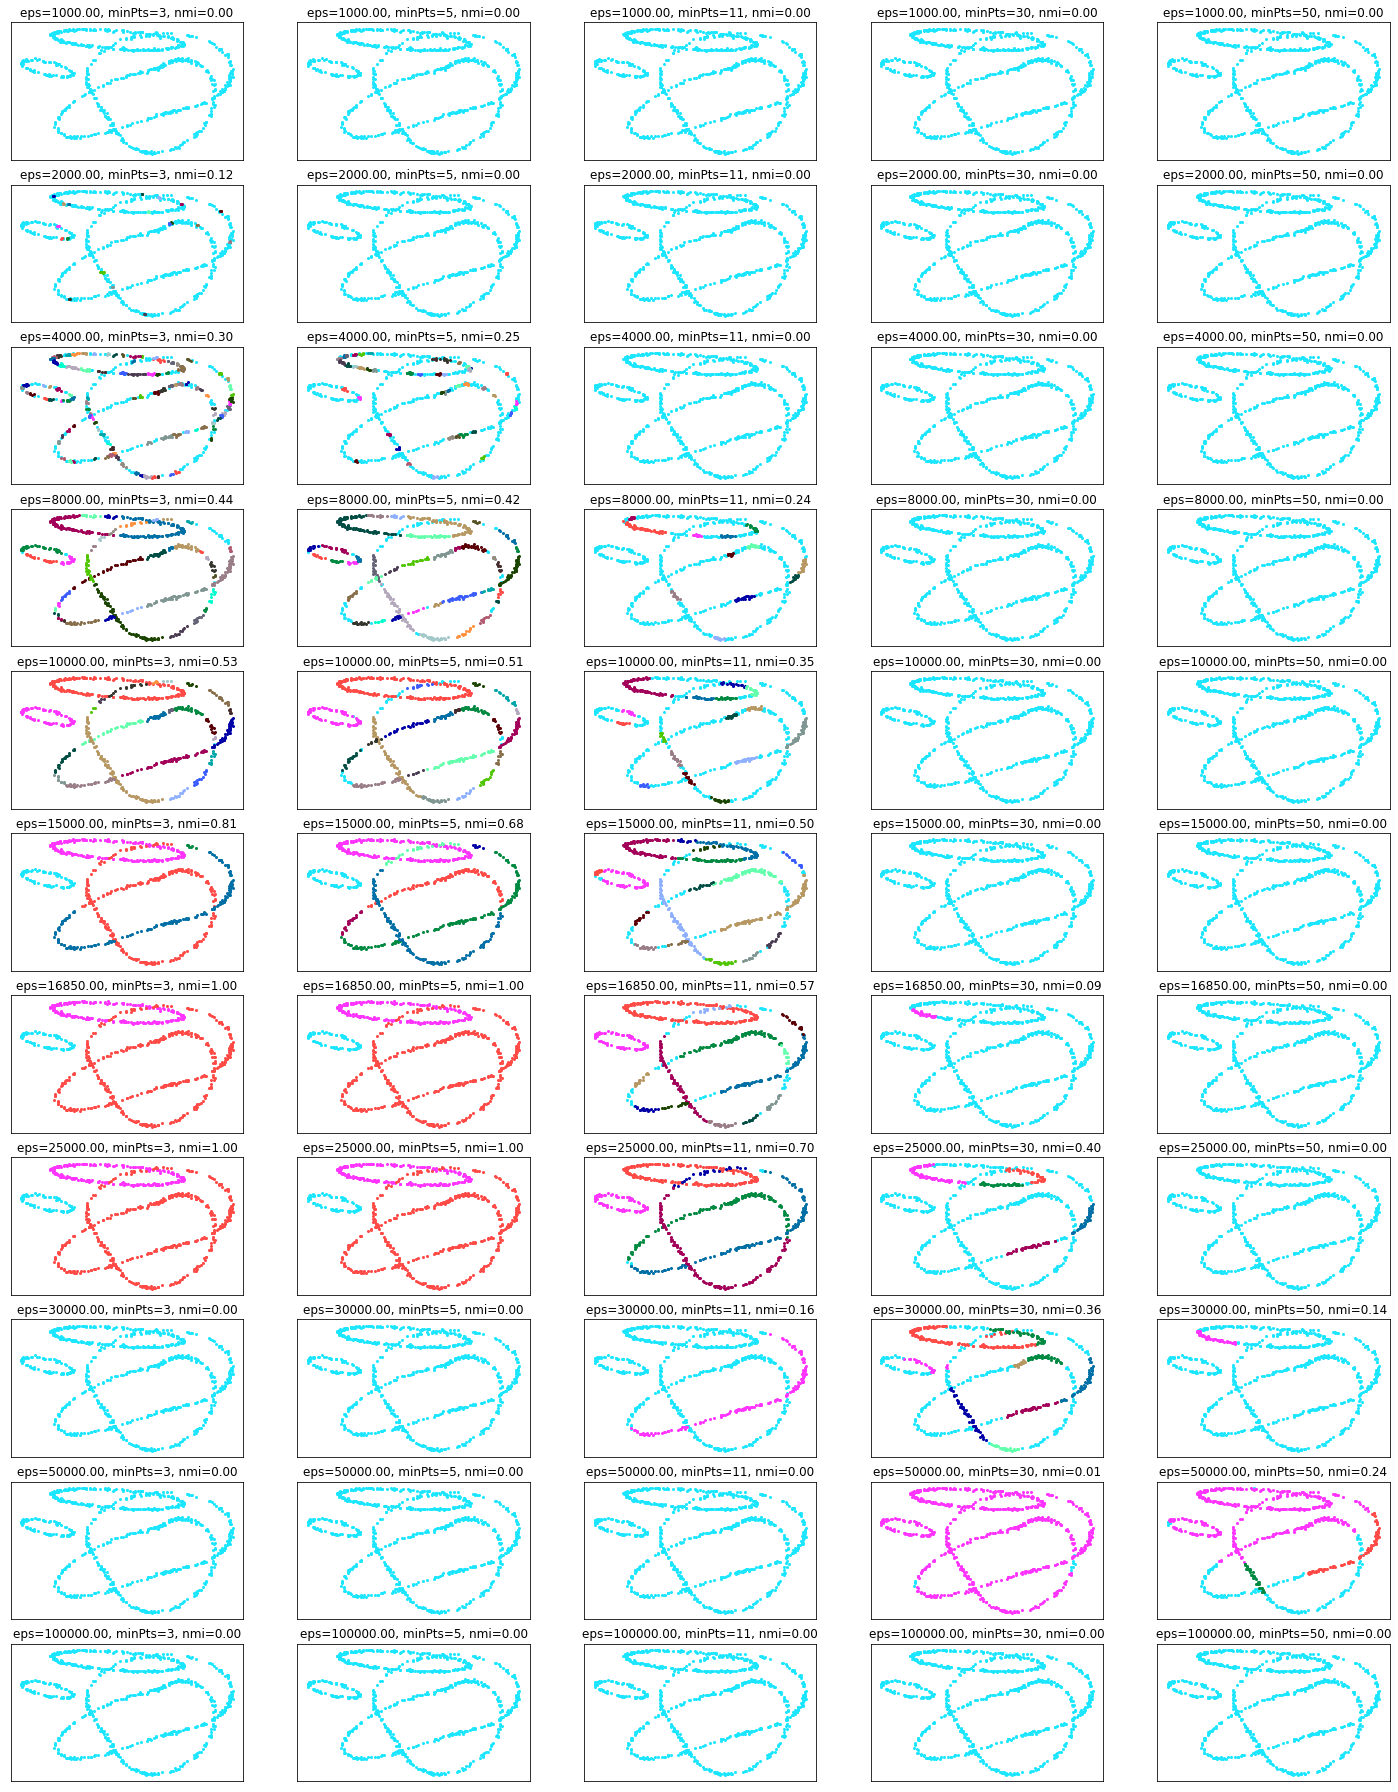

In [90]:
eps_range = [1000,2000,4000,8000,10000, 15000, 16850, 25000, 30000, 50000, 100000]
min_sample_range = [3,5,11,30,50]
fig, ax = plt.subplots(len(eps_range),len(min_sample_range),figsize=(20,25))
n_labels_for_method = []
for i, eps in enumerate(eps_range):
    for j, min_samples in enumerate(min_sample_range):
        model = DBSCAN(eps=eps, min_samples=min_samples)
        model.fit(X)
        y = model.labels_
        #keeping track on the number of labels for each method
        n_labels_for_method.append(list(set(y)))
        plotting_ax(X,y,ax[i,j])
        nmi=NMI(y, y_true)
        ax[i,j].set_title('eps=%.2f, minPts=%i, nmi=%.2f'%(eps,min_samples,nmi))
        ax[i,j].get_xaxis().set_ticks([])
        ax[i,j].get_yaxis().set_ticks([])
plt.tight_layout(h_pad=0.5)
plt.show()

In [106]:
minPts3 = n_labels_for_method[::5]
minPts5 = n_labels_for_method[1::5]
minPts11 = n_labels_for_method[2::5]
minPts30 = n_labels_for_method[3::5]
minPts50 = n_labels_for_method[4::5]

devo printare eps vs n labels

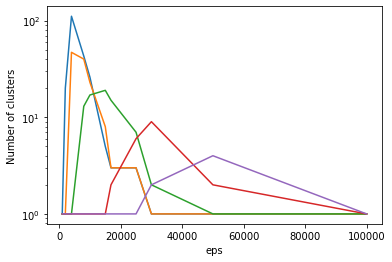

In [144]:
minPts3 = n_labels_for_method[::5]
minPts5 = n_labels_for_method[1::5]
minPts11 = n_labels_for_method[2::5]
minPts30 = n_labels_for_method[3::5]
minPts50 = n_labels_for_method[4::5]

minPts3_y = []
minPts5_y = []
minPts11_y = []
minPts30_y = []
minPts50_y = []

for i in range(len(eps_range)):
    minPts3_y.append(len(minPts3[i]))
    minPts5_y.append(len(minPts5[i]))
    minPts11_y.append(len(minPts11[i]))
    minPts30_y.append(len(minPts30[i]))
    minPts50_y.append(len(minPts50[i]))

plt.plot(eps_range,minPts3_y)
plt.plot(eps_range,minPts5_y)
plt.plot(eps_range,minPts11_y)
plt.plot(eps_range,minPts30_y)
plt.plot(eps_range,minPts50_y)
plt.xlabel('eps')
plt.ylabel('Number of clusters')
plt.yscale('log')
plt.show()


In [137]:
minPts11_y

[1, 1, 1, 13, 17, 19, 15, 7, 2, 1, 1]